<a href="https://colab.research.google.com/github/NicolasPCS/Image-Classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot

import os
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from pathlib import Path
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score

from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/Tesis/New_Images_Dataset')

train_data_dir = download_dir/'training_set'
test_data_dir =download_dir/'validation_set'

class_subset = sorted(os.listdir(download_dir/'training_set'))[:16] # Using only the first 10 classes
#class_subset = len(os.listdir(test_data_dir))

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = ResNet50V2(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape, pooling=None)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)  # Número de unidades ajustado
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=16

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

# First we'll train the model without Fine-tuning
resnet50v2_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
%%time

resnet50v2_history = resnet50v2_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
resnet50v2_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

resnet50v2_preds = resnet50v2_model.predict(testgen)
resnet50v2_pred_classes = np.argmax(resnet50v2_preds, axis=1)

resnet50v2_acc = accuracy_score(true_classes, resnet50v2_pred_classes)
print("resnet50v2 Model Accuracy without Fine-Tuning: {:.2f}%".format(resnet50v2_acc * 100))

In [ ]:
saved_model_path = f"/content/drive/MyDrive/Tesis/Trained models/TranferLearning/saved_resnet50v2_53.28%"
tf.saved_model.save(resnet50v2_model, saved_model_path)

resnet50v2_model.save('/content/drive/MyDrive/Tesis/Trained models/TranferLearning/resnet50v2_53.28%.hdf5')

In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.00001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
resnet50v2_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

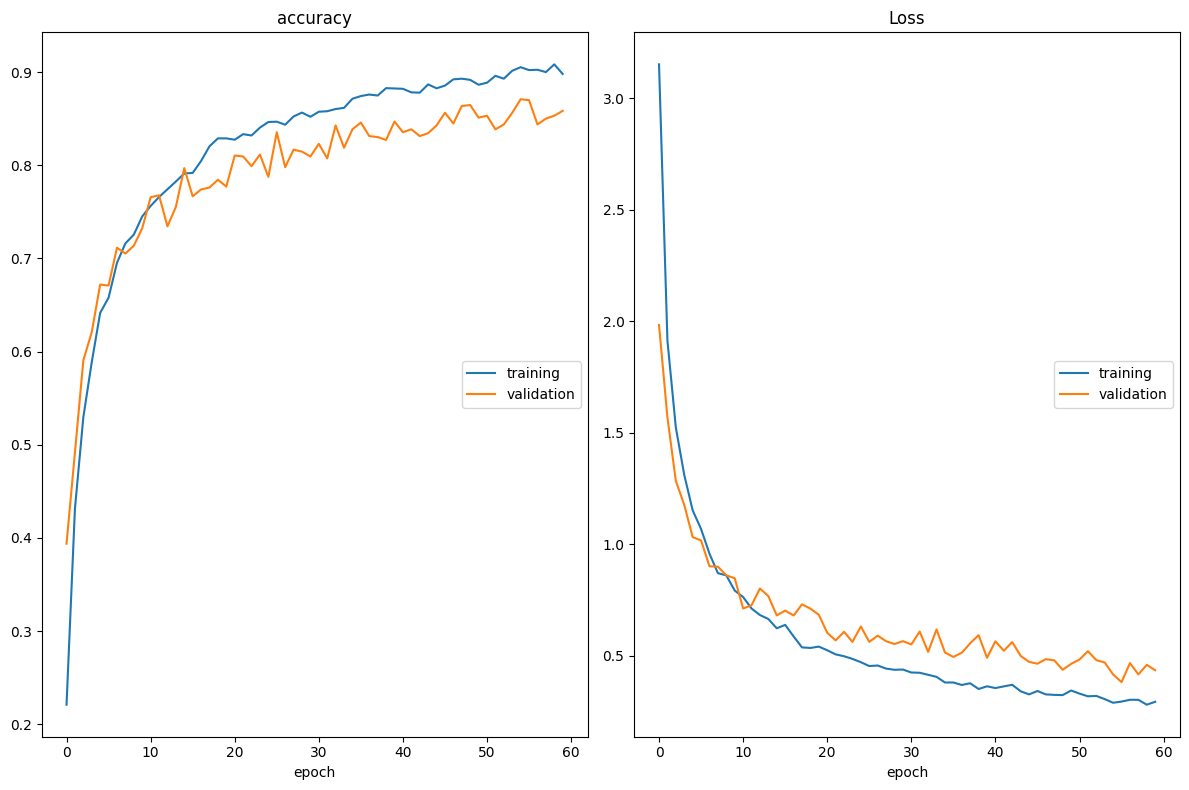

accuracy
	training         	 (min:    0.221, max:    0.908, cur:    0.898)
	validation       	 (min:    0.394, max:    0.871, cur:    0.858)
Loss
	training         	 (min:    0.280, max:    3.153, cur:    0.293)
	validation       	 (min:    0.381, max:    1.984, cur:    0.435)
87/87 [==============================] - 99s 1s/step - loss: 0.2930 - accuracy: 0.8979 - val_loss: 0.4346 - val_accuracy: 0.8583
CPU times: user 1h 34min 53s, sys: 5min 53s, total: 1h 40min 46s
Wall time: 1h 40min


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
resnet50v2_ft_history = resnet50v2_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# Generate predictions
resnet50v2_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

resnet50v2_preds_ft = resnet50v2_model_ft.predict(testgen)
resnet50v2_pred_classes_ft = np.argmax(resnet50v2_preds_ft, axis=1)

resnet50v2_acc_ft = accuracy_score(true_classes, resnet50v2_pred_classes_ft)
print("resnet50v2 Model Accuracy with Fine-Tuning: {:.2f}%".format(resnet50v2_acc_ft * 100))

2487/2487 [==============================] - 26s 10ms/step
resnet50v2 Model Accuracy with Fine-Tuning: 54.64%


In [ ]:
saved_model_path = f"/content/drive/MyDrive/Tesis/Trained models/Fine-tuning/saved_inceptionresnetv2_54.64%"
tf.saved_model.save(resnet50v2_model, saved_model_path)

resnet50v2_model_ft.save('/content/drive/MyDrive/Tesis/Trained models/Fine-tuning/inceptionresnetv2_54.64%.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
